In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fasthigashi.FastHigashi_Wrapper import *
# Set the path to the configuration file, change it accordingly
# The format of the config file is the same as the Higashi config JSON
config = "/home/rzhang/fast_higashi_git/config_dir/config_m3c_Liu_mousehippo_500k.JSON"

In [3]:
# initialize the model
wrapper = FastHigashi(config_path=config,
                      path2input_cache=None, # when setting at None, will use the temp_dir on the JSON file
                      path2result_dir=None, # same as above
                      off_diag=100,
                      filter=True,
                      do_conv=False, # at coarser resolution for high cov data, recommend to be False
                      do_rwr=True, # Partial random walk with restart, False yields to similar results, but more sensitive to the initialization
                      do_col=False,
                      no_col=False)


setting to gpu:4


In [4]:
# From contact pairs to the sparse matrices and store them on disk
if not os.path.exists(os.path.join(wrapper.temp_dir, "raw", "%s_sparse_adj.npy" % wrapper.chrom_list[0])):
    start = time.time()
    wrapper.fast_process_data()
    print("contact pairs to sparse mtx takes: %.2f s" % (time.time() - start))


generating start/end dict for chromosome
extracting from filelist.txt


  0%|          | 0/5398 [00:00<?, ?it/s]

fast process finishes
contact pairs to sparse mtx takes: 85.82 s


In [5]:
# packing data from sparse matrices to sparse tensors
start = time.time()
wrapper.prep_dataset(batch_norm=False) # we don't have batch_id provided so, set as False
print("packing sparse mtx takes: %.2f s" % (time.time() - start))

total number of cells that pass qc check 5054 bad 344 total: 5398
cache file = /home/rzhang/Higashi/Temp/m3c_Liu_mousehippo_500k/cache_intra_500000_offdiag_100_.pkl


packing sparse mtx into sparse tensors:   0%|          | 0/19 [00:00<?, ?it/s]

Sorting indices in sparse tensors:   0%|          | 0/19 [00:00<?, ?it/s]

saving cached input to /home/rzhang/Higashi/Temp/m3c_Liu_mousehippo_500k/cache_intra_500000_offdiag_100_.pkl
gpu mem
c_nvmlMemory_t(total: 25757220864 B, free: 25430523904 B, used: 326696960 B)
sparsity 0.04694323985098866
do_conv False do_rwr True do_col False
recommend_bs_cell [5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054, 5054] pinning memory
packing sparse mtx takes: 62.14 s


In [6]:

wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=256,
                  n_iter_parafac=1,
                  tol=2e-5 # In the original manuscript, we use this 3e-4 tolerance, but later we found that setting it to smaller ones might lead to better performance on some data. For this dataset, it leads to more robust results to the initialization
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=256,
                   n_iter_parafac=1
                   )

dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
time elapsed: 0.01


initializing params:   0%|          | 0/19 [00:00<?, ?it/s]

rwr iters: [7 7 6 6 7 6 7 6 6 6 6 6 6 7 6 6 6 6 5]
time elapsed: 22.16
finish init
Starting iteration 0

PARAFAC2 re=5.656 takes 13.7s
Starting iteration 1

PARAFAC2 re=0.426 9.94e-01 variation min9.9e-01 at chrom 18, max1.0e+00 at chrom 0 takes 14.4s
Starting iteration 2

PARAFAC2 re=0.421 2.45e-02 variation min1.4e-02 at chrom 5, max3.2e-02 at chrom 4 takes 14.6s
Starting iteration 3

PARAFAC2 re=0.414 3.39e-02 variation min2.6e-02 at chrom 14, max4.1e-02 at chrom 15 takes 14.8s
Starting iteration 4

PARAFAC2 re=0.411 1.47e-02 variation min1.3e-02 at chrom 10, max1.9e-02 at chrom 1 takes 14.9s
Starting iteration 5

PARAFAC2 re=0.410 5.78e-03 variation min4.8e-03 at chrom 18, max1.1e-02 at chrom 5 takes 15.0s
Starting iteration 6

PARAFAC2 re=0.409 2.84e-03 variation min1.6e-03 at chrom 4, max6.2e-03 at chrom 5 takes 15.0s
Starting iteration 7

PARAFAC2 re=0.409 1.68e-03 variation min8.0e-04 at chrom 4, max3.8e-03 at chrom 5 takes 15.1s
Starting iteration 8

PARAFAC2 re=0.409 1.12e-03

dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh'])


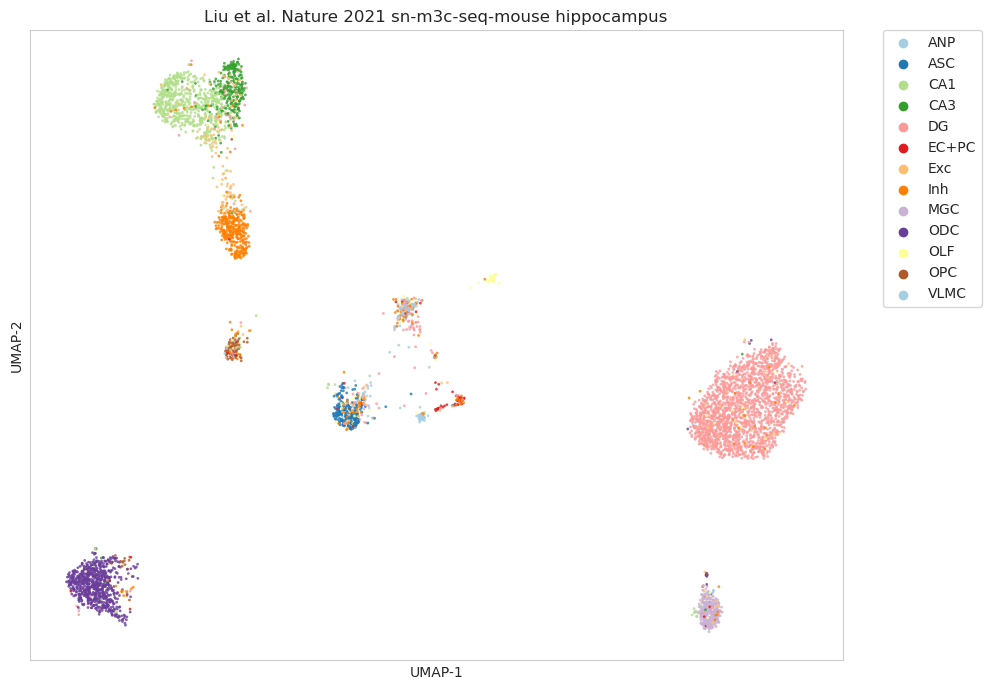

In [14]:
# getting embedding
embed = wrapper.fetch_cell_embedding(final_dim=256,
                                     restore_order=False)
# The returned embed is a dictionary that stores the embeddings after different ways of post-processing.
# 'embed_l2_norm' or 'embed_l2_norm_correct_coverage_fh' usually yields the best results, the latter one represents linear correction of sequencing depth bias.
print (embed.keys())

from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

embedding = embed['embed_l2_norm_correct_coverage_fh']
vec = UMAP(n_components=2, n_neighbors=25, min_dist=0.3, random_state=0).fit_transform(embedding)
# pull the visualization palette from the config file


fig = plt.figure(figsize=(10, 7))
col = 'cell type summary'
ax = sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], s=4, alpha=0.8, linewidth=0, palette="Paired", hue_order=np.unique(wrapper.label_info[col]))
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_title("Liu et al. Nature 2021 sn-m3c-seq-mouse hippocampus")
plt.tight_layout()
plt.show()
